# Calculate Coupling Coefficients
Two split rings are placed in a broadside coupled configuration. The scalar model of each resonator is augmented by additional coefficients representing the coupling between them.

In [D. A. Powell et al, Phys. Rev. B 82, 155128 (2010)](http://dx.doi.org/10.1103/PhysRevB.82.155128) similar coefficients were calculated under the quasi-static approximation for a single mode only. Here the effects of retardation and radiation losses are included, as are the contributions of multiple modes of each ring.

In [1]:
# setup 2D and 3D plotting 
%matplotlib notebook
from openmodes.ipython import init_3d, matplotlib_defaults
init_3d()
matplotlib_defaults()
import matplotlib.pyplot as plt

import numpy as np

import os.path as osp

import openmodes
from openmodes.constants import c, eta_0
from openmodes.model import ModelPolyInteraction
from openmodes.sources import PlaneWaveSource

As in previous examples, we load a pair of SRRs, place them in the simulation and visualise the result.

In [2]:
outer_radius = 4e-3

sim = openmodes.Simulation(name="example4")
srr = sim.load_mesh(osp.join(openmodes.geometry_dir, "SRR.geo"), 
                    parameters={'inner_radius': 2.5e-3, 'outer_radius': outer_radius},
                    mesh_tol=0.7e-3)

srr1 = sim.place_part(srr)
srr2 = sim.place_part(srr, location=[0e-3, 0e-3, 2e-3])
srr2.rotate([0, 0, 1], 180)

In [3]:
sim.plot_3d()

We find the singularities for one of the two identical rings.

In [4]:
start_freq = 1e9
start_s = 2j*np.pi*start_freq

num_modes = 3
mode_s, mode_j = sim.singularities(start_s, num_modes, part=srr1);

We now use these singularities to construct a model for each of the rings. The coupling between them is also modelled, by weighting the mutual coupling terms with the modal currents. These weighted interaction terms are then fitted by a polynomial, in this case of 4th order.

Here we construct two different models, one considering only the fundamental mode of each ring, and another considering the first and third modes. Due to symmetry, the second mode of each ring does not play a part in the hybridised modes which will be considered here.

In [5]:
model_modes = [[0], [0, 2]]
num_models = len(model_modes)
models = []
projections = []

# the order of the fitting polynomial
poly_order = 4

# the maximum frequency for which to model the mutual interaction terms
s_max = 2j*np.pi*10e9

for modes in model_modes:
    # these projections are needed later for the vector
    projections.append([(srr1, mode_j["J", :, modes].T), (srr2, mode_j["J", :, modes].T)])
    
    # for each part, specify which modes will be used to construct the model
    parts_modes = [(srr1, mode_s[modes], mode_j["J", :, modes].T),
                   (srr2, mode_s[modes], mode_j["J", :, modes].T)]

    models.append(ModelPolyInteraction(sim.operator, parts_modes, poly_order, s_max))

mutual_model = models[-1].models[srr1, srr2]

The polynomial coupling models have real coefficients, making them physically meaningful in both the time and frequency domains. The mutual impedance $Z$ is split into two parts $Z_{mut}(s) = s L_{mut}(s) + S_{mut}(s)/s$, and in the quasi-static limit, these parts correspond to the inductive and capacitive coupling respectively. We can now inspect the coefficients of the fitting polynomials for the coupling between fundamental modes. Note that a scaling factor is applied to the frequency $s$ to ensure numerical stability of the polynomial fit.

$s' = s/s_0$

$L_{mut}(s) = L_0 + s'L_1 + s'^2L_2 + s'^3L_3$

$S_{mut}(s) = S_0 + s'S_1 + s'^2S_2 + s'^3S_3$

In [6]:
fundamental_interaction = mutual_model.models[0][0]
print("Scaling factor s_0: %.5e" % mutual_model.scale_factor)
print("Coefficients of mutual L %s" % str(fundamental_interaction[0]))
print("Coefficients of mutual S %s" % str(fundamental_interaction[1]))

Scaling factor s_0: 3.14159e+09
Coefficients of mutual L [  8.13118429e-11   2.69506614e-12  -1.38042377e-13   4.99420466e-15]
Coefficients of mutual S [ -2.16985273e+11   1.16911625e+09   1.41050800e+08  -5.06524153e+06]


Now we iterate through all frequencies, and calculate the model parameters. Their accuracy is demonstrated by using them to calculate the extinction cross-section. For reference purposes, this will be compared with the direct calculation.

In [7]:
num_freqs = 500

freqs = np.linspace(5e9, 10e9, num_freqs)
e_inc = np.array([0, 1, 0], dtype=np.complex128)
k_hat = np.array([1, 0, 0], dtype=np.complex128)
plane_wave = PlaneWaveSource(e_inc, k_hat)

extinction_tot = np.empty(num_freqs, np.complex128)
extinction_single = np.empty(num_freqs, np.complex128)
extinction_sem = np.empty((num_freqs, num_models), np.complex128)

# store the mutual coupling coefficients for plotting purposes
mutual_L = np.empty(num_freqs, np.complex128)
mutual_S = np.empty(num_freqs, np.complex128)

for freq_count, s in sim.iter_freqs(freqs):
    impedance = sim.impedance(s)
    V = sim.source_vector(plane_wave, s)

    # For reference directly calculate extinction for the complete system, and for a single ring 
    extinction_tot[freq_count] = np.vdot(V, impedance.solve(V))    
    extinction_single[freq_count] = np.vdot(V[srr1], impedance[srr1, srr1].solve(V[srr1]))

    # extract the mutual coupling term for the fundamental mode of each ring
    mutual_L[freq_count], mutual_S[freq_count] = mutual_model.LS(s, 0, 0)
    
    # calculate the extinction using the model based on modes of each element
    for model_count in range(num_models):
        V_sem = V.weight(projections[model_count])
        #Z_sem = models[model_count].impedance(s)
        extinction_sem[freq_count, model_count] = np.vdot(V_sem, models[model_count].solve(s, V_sem))

Now we can study the coupling coefficients. It can be seen that both $L_{mut}$ and $S_{mut}$ show quite smooth behaviour over this wide frequency range. This justifies the use of a low-order polynomial model for the interaction terms. This frequency variation is due to retardation, which is not very strong for such close separation.

However, the retardation is still strong enough to make the imaginary parts of these coupling terms non-negligible. These parts corresponds to the real part of the mutual impedance, and mean that the coupling affects not only the stored energy, but also the rate of energy loss due to radiation by the modes.

<IPython.core.display.Javascript object>


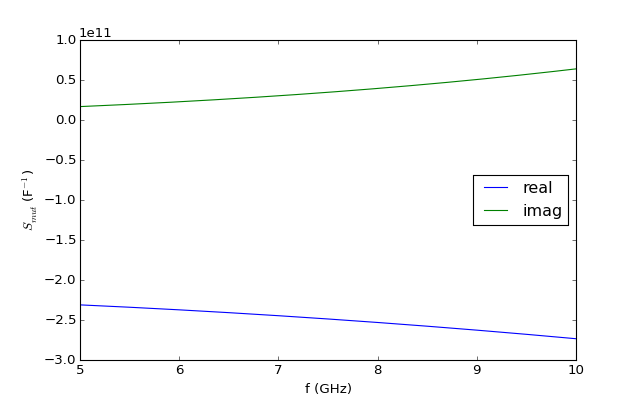

In [8]:
plt.figure()
plt.plot(freqs*1e-9, mutual_S.real, label='real')
plt.plot(freqs*1e-9, mutual_S.imag, label='imag')
plt.legend(loc="center right")
plt.ylabel('$S_{mut}$ (F$^{-1}$)')
plt.xlabel('f (GHz)')
plt.show()

<IPython.core.display.Javascript object>


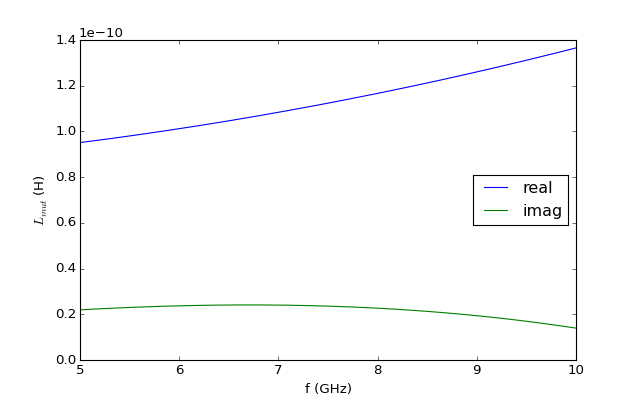

In [9]:
plt.figure()
plt.plot(freqs*1e-9, mutual_L.real, label='real')
plt.plot(freqs*1e-9, mutual_L.imag, label='imag')
plt.legend(loc="center right")
plt.ylabel('$L_{mut}$ (H)')
plt.xlabel('f (GHz)')
plt.show()

The extinction cross section is now plotted for the pair of rings, using both the simpler model and the direct calculation. Additionally, the cross section of a single ring is shown. It can be seen that this fundamental mode of a single ring is split into two coupled modes. Due to the coupling impedance being complex, the hybridised modes have different widths.

In [10]:
# normalise the extinction to the incident power density and cross-sectional area
area = np.pi*(outer_radius)**2
incident_power = np.vdot(e_inc, e_inc)/eta_0

Q_single = extinction_single/incident_power/area
Q_pair = extinction_tot/incident_power/area
Q_sem = extinction_sem/incident_power/area

<IPython.core.display.Javascript object>


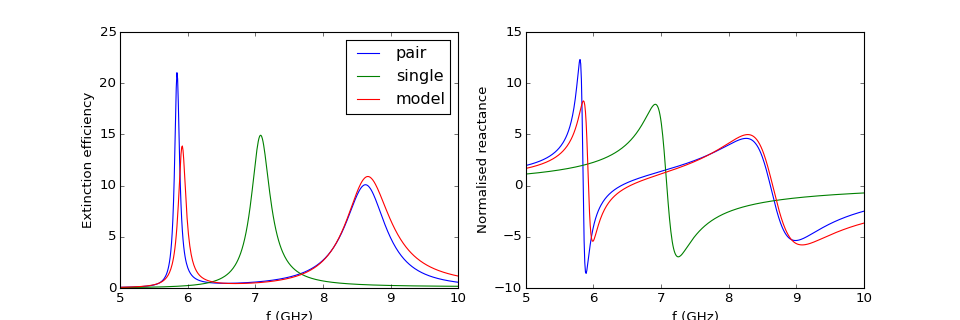

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(freqs*1e-9, Q_pair.real, label='pair')
plt.plot(freqs*1e-9, Q_single.real, label='single')
plt.plot(freqs*1e-9, Q_sem[:, 0].real, label='model')
plt.xlim(freqs[0]*1e-9, freqs[-1]*1e-9)
plt.xlabel('f (GHz)')
plt.ylabel('Extinction efficiency')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(freqs*1e-9, Q_pair.imag)
plt.plot(freqs*1e-9, Q_single.imag)
plt.plot(freqs*1e-9, Q_sem[:, 0].imag)
plt.xlim(freqs[0]*1e-9, freqs[-1]*1e-9)
plt.ylabel('Normalised reactance')
plt.xlabel('f (GHz)')
plt.show()

In the above figure, it can be seen that the simple model of interaction between the rings gives quite good agreement. This can be improved by using the model which considers the two modes of each ring. While the modes on the same ring are independent of each other, between meta-atoms all modes couple to each other, thus there are 3 distinct coupling impedances, and two distinct self impedance terms.

The results of this model are plotted below, showing the improved accuracy by accounting for the higher-order mode.

<IPython.core.display.Javascript object>


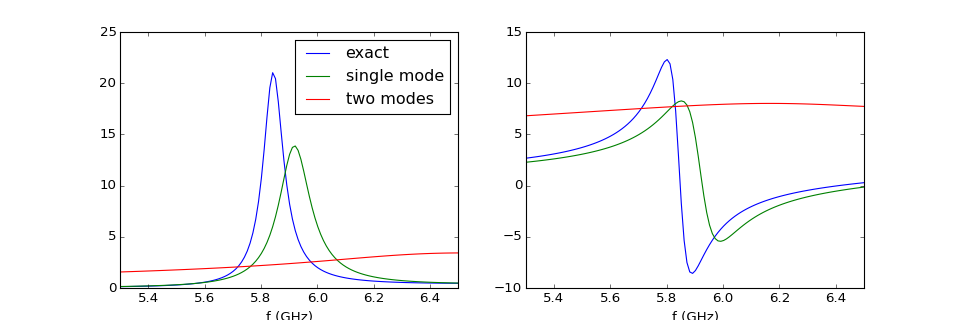

In [12]:
# 2 modes
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(freqs*1e-9, Q_pair.real, label='exact')
plt.plot(freqs*1e-9, Q_sem[:, 0].real, label='single mode')
plt.plot(freqs*1e-9, Q_sem[:, 1].real, label='two modes')
plt.legend(loc="upper right")
plt.xlim(5.3, 6.5)
plt.xlabel('f (GHz)')
plt.subplot(122)
plt.plot(freqs*1e-9, Q_pair.imag)
plt.plot(freqs*1e-9, Q_sem[:, 0].imag)
plt.plot(freqs*1e-9, Q_sem[:, 1].imag)
plt.xlim(5.3, 6.5)
plt.xlabel('f (GHz)')
plt.show()